In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

True

In [4]:
# import os
# del os.environ['HF_TOKEN']
# os.environ.get("HF_TOKEN")

In [5]:
from autodm.llm import get_llm
from autodm.roll import Dice, DiceType
from autodm.character import Character
from autodm.locaitons import Location, LocationGraph, setup_new_locations, LLMTextCompletionProgram
from autodm.adventurelog import AdventureLog
from autodm.storyline import StoryLineWithStoryItems

from typing import List
from rich import print

/Users/michaelfrantz/miniconda3/envs/autodm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/michaelfrantz/miniconda3/envs/autodm/lib/python3.11/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [6]:
locations = setup_new_locations(storyline="The adventurers enter a sandy desert region")

In [7]:
region = locations[locations.list_locations('region').pop()]
city = locations[locations.list_locations('city').pop()]

In [8]:
building = city.generate_child(type='building', storyline="The adventurers enter the wizard's guild")
room1 = building.generate_child(storyline="The adventurers find and enter the wizard's library.")
room2 = building.generate_child(storyline="The adventurers find and enter thewizard's alchemy lab")
room3 = building.generate_child(storyline="The adventurers find and enter thewizard's training range")
locations.add_location(building)
locations.add_location(room1)
locations.add_location(room2)
locations.add_location(room3)
locations.set_current_location(room1.name)

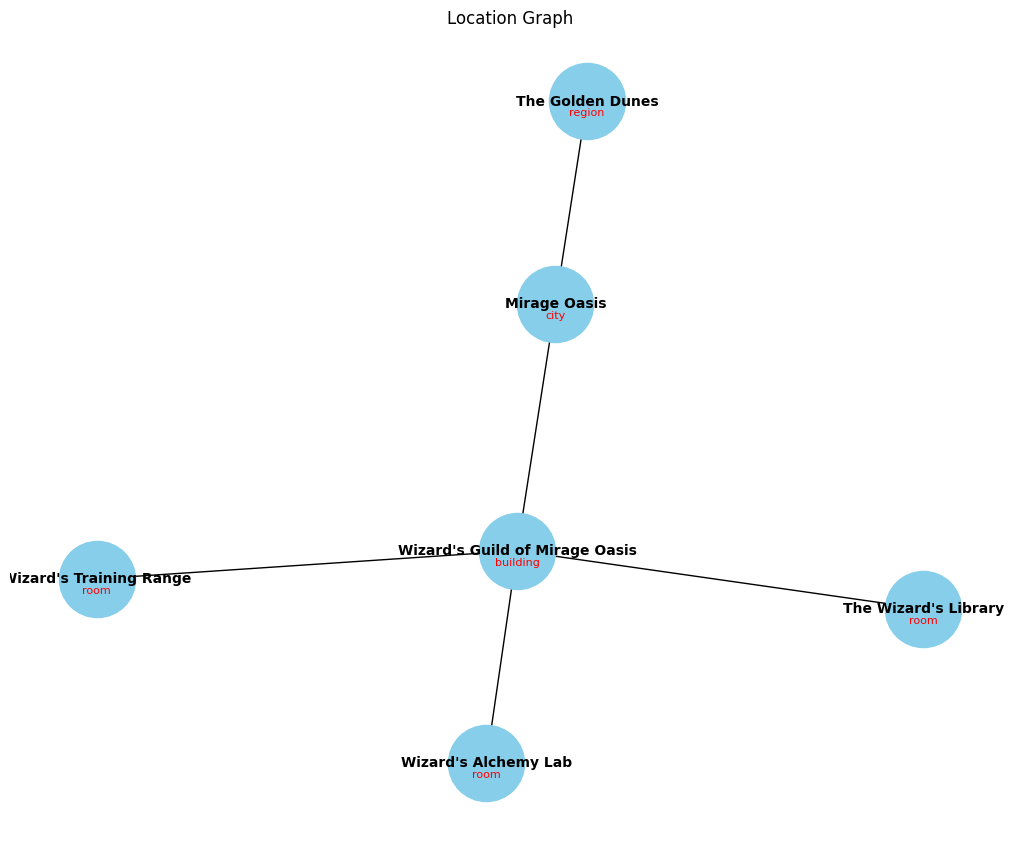

In [9]:
locations.visualize()

In [10]:
character = Character.generate(level=0)
print(character)

Character(
    chr_class='fighter',
    chr_race='human',
    name='Gorthok the Unyielding',
    attributes=Attributes(strength=17, dexterity=20, constitution=18, intelligence=12, wisdom=20, charisma=3),
    level=0,
    max_hp=28,
    hp=28,
    spells=[],
    equipment=[]
)

In [11]:
story = StoryLineWithStoryItems.generate(character, city, region, locations)

RetryError: RetryError[<Future at 0x347d48250 state=finished raised RetryError>]

In [ ]:
print(story)

In [ ]:
from llama_index.core.tools import FunctionTool
from llama_index.core.agent import ReActAgent
from llama_index.core.program import LLMTextCompletionProgram
from llama_index.core import PromptTemplate
from pydantic import BaseModel, Field
import typing as T

In [ ]:
def get_current_location(*args, **kwargs) -> str:
    """
    Returns the name of the current location.
    
    Returns:
        str: The name of the current location.
    """
    return locations.current_location.name

def locaiton_info(location_name, *args, **kwargs) -> str:
    """
    Returns the information about a location.
    
    Args:
        location_name (str): The name of the location.
        
    Returns:
        str: The information about the location.
    """
    if location_name not in locations.list_locations():
        return f"Location {location_name} not found. Use list_locations or get_current_neighbors to see available locations, or create a new location."
    loc = locations[location_name].model_dump()
    s = "\n".join([f"{k}: {v}" for k, v in loc.items()])
    return s

def get_current_neighbors(num_skips:int=1, *args, **kwargs) -> List[str]:
    """
    Returns the names of the neighbors of the current location.
    
    Args:
        num_skips (int): The number of steps to skip in the graph traversal.
        
    Returns:
        List[str]: The names of the neighbors of the current location.
    """
    return locations.current_neighbors(num_skips)

def add_new_location(storyline:str, parent_name:str=None, location_name:str=None, *args, **kwargs) -> str:
    """
    Adds a new location to the location graph.
    
    Args:
        storyline (str): The storyline related to the creation of the new location. 
        parent_name (str): The name of the parent location. If none is given, the current location is used.
        location_name (str): The name of the location. If none is given, one will be made up.
        
    Returns:
        str: The name of the new location.
    """
    if not parent_name:
        parent = locations.current_location
    else:
        parent = locations[parent_name]
    kwargs = {}
    if location_name is not None:
        kwargs["name"] = location_name
    location = parent.generate_child(storyline=storyline, **kwargs)
    locations.add_location(location)
    return location.name

def travel_plan(destionation_name:str, *args, **kwargs) -> List[str]:
    """
    Returns a list of location names that the character will travel through to reach the destination.

    Args:
        destionation_name (str): The name of the destination location.

    Returns:
        str: The name of the destination location.

    Example:
    travel_plan(destination_name="Doom's chasm")
    """
    return locations.travel_plan(destionation_name)

def travel_to(destination_name:str, *args, **kwargs) -> str:
    """
    Travels to a location.
    
    Args:
        destination_name (str): The name of the destination location.
        
    Returns:
        str: The name of the destination location.
    """
    locations.set_current_location(destination_name)
    return locations.current_location.name

In [ ]:
location_tools = [
    FunctionTool.from_defaults(get_current_location),
    FunctionTool.from_defaults(locaiton_info),
    FunctionTool.from_defaults(add_new_location),
    FunctionTool.from_defaults(travel_plan),
    FunctionTool.from_defaults(travel_to),
    FunctionTool.from_defaults(get_current_neighbors)
]

In [ ]:
location_agent = ReActAgent.from_tools(location_tools, llm=get_llm(), verbose=2)
# location_agent = StructuredPlannerAgent.from_tools(location_tools, llm=get_llm(), verbose=2)

In [ ]:
step_splitting_instructions = """\
You will get a piece of a story from a dungeons and dragons campaign. \
The task is to break the story into steps that relate to location. \
If no steps are required (for example, the storyline is a conversation), return an empty list. \
Please follow the requested JSON schema. \

Examples:
------
Input: "The adventurers enter the wizard's guild."
Answer: {"steps": ["What is the current location?", \
"What are the available locations?", \
'Does the wizard's guild exist?', \
"Create the wizard's guild if it doesn't exist.", \
"Create a travel plan to the wizard's guild.", \
"Travel to the Mirendale wizard's guild."]}
------
Input: "The adventurers set out on a journey to the city of Mirendale."
Answer: {"steps": ["What is the current location?", \
"Create the city of Mirendale if it doesn't exist", \
"Create a travel plan to the city of Mirendale.", \
"Take the first step in traveling to Mirendale."]}
------

Now perform the demonstrated task on the folloing input:
"""

step_splitting_template = PromptTemplate("""\
{step_splitting_instructions}
{storyline}
Answer: \
""").partial_format(step_splitting_instructions=step_splitting_instructions)

class Steps(BaseModel):
    steps: List[str] = Field([], description="The steps to take to complete the storyline.")

split_prompts_program = LLMTextCompletionProgram.from_defaults(output_cls=Steps, llm=get_llm(output_cls=Steps), prompt=step_splitting_template)

In [ ]:
# steps = split_prompts_program(storyline="Let's go to the alchemy lab.").steps

In [ ]:
inst = f"""\
Here is the current location: {locations.current_location.name}
Here are the nearest locations: {locations.current_neighbors()}
Let's travel to the alchemist's lab.
"""

In [ ]:
output = location_agent.chat(inst)

In [ ]:
print(output)

In [ ]:
print(output.response)

In [ ]:
locations.visualize()

In [ ]:
locations.list_locations()

In [ ]:
locations.visualize()